In [1]:
import scanpy as sc
import OTHarmonizer as oth
import warnings

warnings.filterwarnings("ignore")

2025-12-05 02:22:27.841946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-05 02:22:27.951794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-05 02:22:27.972623: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-05 02:22:33.928776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/data1/zth/mambaforge/envs/harmonization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonote

## Load data

In [2]:
adata = sc.read_h5ad('/home/zth/data/harmonization_data/real data/HLCA_data.h5ad')
endothelial_adata = adata[adata.obs.original_ann_level_1 == "Endothelial"].copy()
endothelial_adata

AnnData object with n_obs × n_vars = 26513 × 28024
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'o

## Data preprocess

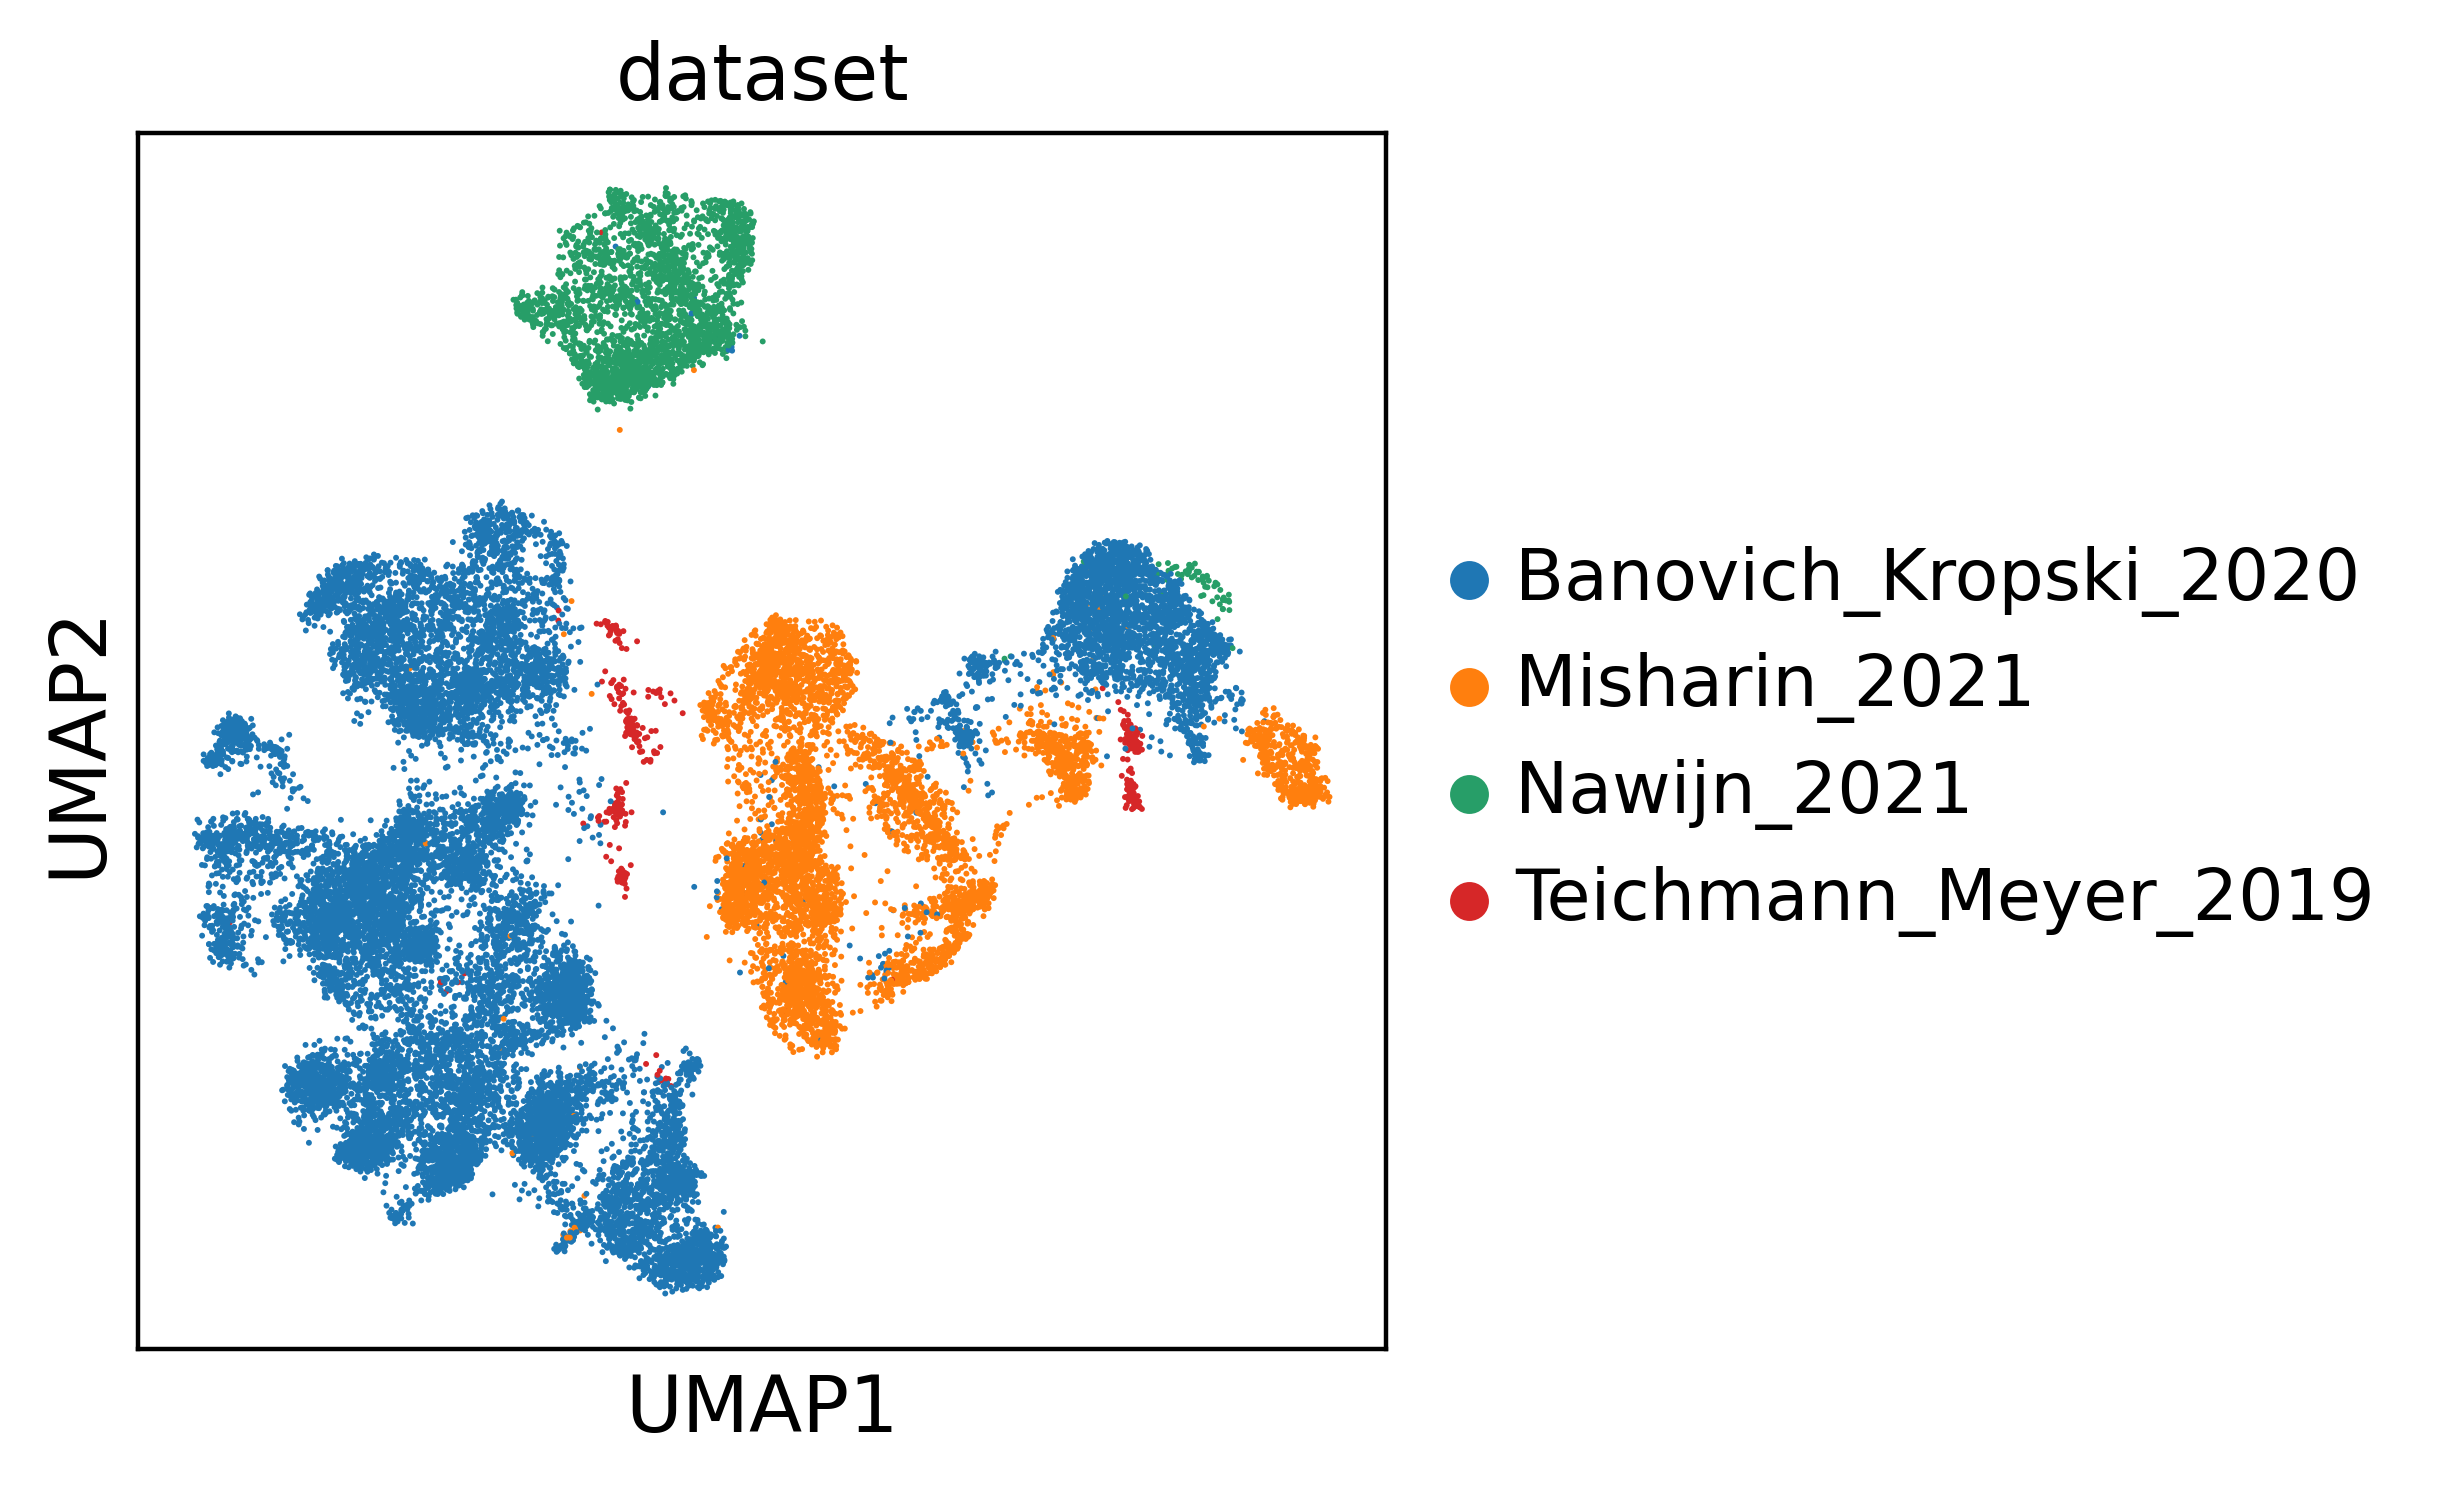

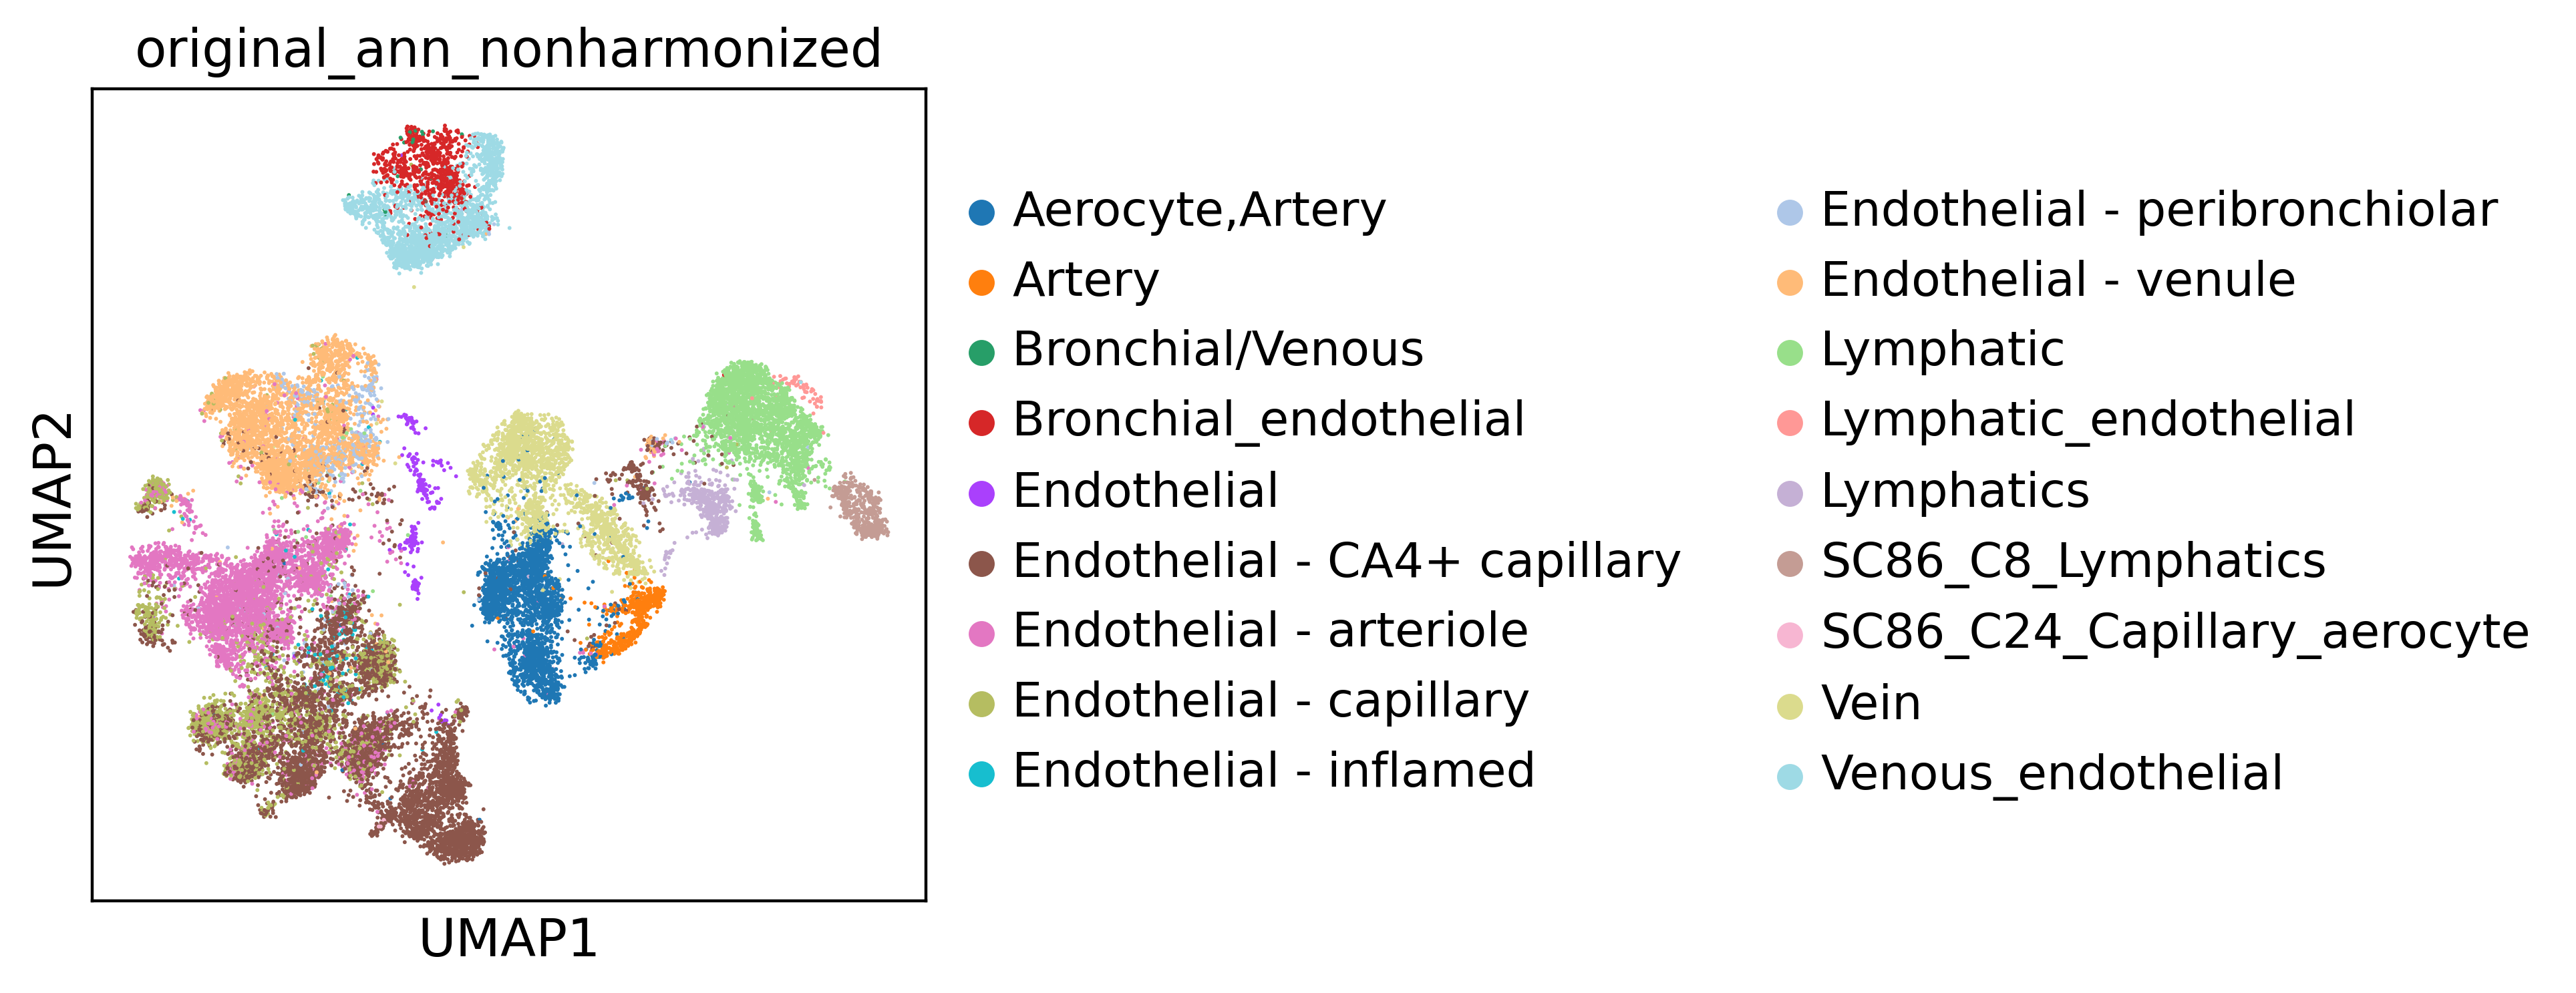

In [3]:
sc.pp.normalize_total(endothelial_adata, target_sum = 1e4)
sc.pp.log1p(endothelial_adata)
sc.pp.highly_variable_genes(endothelial_adata, batch_key = 'dataset', subset = True)
sc.tl.pca(endothelial_adata)
sc.pp.neighbors(endothelial_adata)
sc.tl.umap(endothelial_adata)
sc.pl.umap(endothelial_adata, color = ['dataset'])
sc.pl.umap(endothelial_adata, color = ['original_ann_nonharmonized'])
# endothelial_adata = endothelial_adata[endothelial_adata.obs['original_ann_nonharmonized'] != 'SC86_C8_Lymphatics'].copy()

## Creat ground truth tree

In [4]:
ref_tree_endothelial = oth.create_tree_from_string("""
'root'
----'Teichmann_Meyer_2019-Endothelial'
--------'Misharin_2021-Aerocyte&Artery'
------------'Banovich_Kropski_2020-Endothelial - arteriole'
------------'Banovich_Kropski_2020-Endothelial - capillary'
------------'Banovich_Kropski_2020-Endothelial - CA4+ capillary&Misharin_2021-SC86_C24_Capillary_aerocyte' 
--------'Nawijn_2021-Bronchial_endothelial'
--------'Nawijn_2021-Bronchial/Venous&Banovich_Kropski_2020-Endothelial - peribronchiolar'
--------'Banovich_Kropski_2020-Endothelial - inflamed
--------'Banovich_Kropski_2020-Endothelial - venule&Misharin_2021-Vein&Nawijn_2021-Venous_endothelial'
----'Banovich_Kropski_2020-Lymphatic&Teichmann_Meyer_2019-Lymphatic&Nawijn_2021-Lymphatic_endothelial&Misharin_2021-Lymphatics'
""")


## Using scVI to reduce batch effect

In [5]:
latent = oth.scVI(endothelial_adata, 
'dataset', 
'original_ann_nonharmonized', 
epoch_num=80
)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 80/80: 100%|███████████████████████████████████████████████████████| 80/80 [02:50<00:00,  2.12s/it, v_num=1, train_loss_step=765, train_loss_epoch=784]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 80/80: 100%|███████████████████████████████████████████████████████| 80/80 [02:50<00:00,  2.13s/it, v_num=1, train_loss_step=765, train_loss_epoch=784]
Training completed. Time elapsed: 172.74 seconds


## Do harmonization

In [6]:
root = oth.do_harmonization(
    latent,
    'original_ann_nonharmonized',
    'dataset',
    sample_size=500
)

[Global-Leiden order] resolution=1.0; PCA n_pcs=10; score = n_leiden / n_annotations
                   batch  n_leiden  n_annotations     score
0   Teichmann_Meyer_2019        17              2  8.500000
1            Nawijn_2021        19              4  4.750000
2          Misharin_2021        21              5  4.200000
3  Banovich_Kropski_2020        22              7  3.142857
Initializing tree from Teichmann_Meyer_2019 and Nawijn_2021🌲
Adding annotations from Misharin_2021🍃
Adding annotations from Banovich_Kropski_2020🍃
Batch comparison completed. Time elapsed: 7.6704 seconds


In [7]:
print(root)
oth.benchmark(root,ref_tree_endothelial)

'root'
----'Teichmann_Meyer_2019-Lymphatic&Nawijn_2021-Lymphatic_endothelial&Misharin_2021-Lymphatics&Banovich_Kropski_2020-Lymphatic'
----'Teichmann_Meyer_2019-Endothelial'
--------'Nawijn_2021-Venous_endothelial&Misharin_2021-Vein'
------------'Banovich_Kropski_2020-Endothelial - peribronchiolar'
------------'Banovich_Kropski_2020-Endothelial - venule'
--------'Misharin_2021-Aerocyte,Artery'
------------'Nawijn_2021-Bronchial/Venous'
------------'Nawijn_2021-Bronchial_endothelial'
----------------'Banovich_Kropski_2020-Endothelial - arteriole'
----------------'Banovich_Kropski_2020-Endothelial - capillary'
--------'Misharin_2021-Artery'
--------'Banovich_Kropski_2020-Endothelial - inflamed'
----'Banovich_Kropski_2020-Endothelial - CA4+ capillary'
--------'Misharin_2021-SC86_C24_Capillary_aerocyte'

nodes of constructed_tree 15.0
nodes of ref_tree 11.0
TED: 11.0
TEDS: 0.56
###################################
total count of sets 9
PCB: 9
PCBS: 0.4425925925925926
#######################

{'TEDS': 0.56, 'PCBS': 0.4425925925925926, 'AH_F1': 0.6288259200789638}